# Import Packages

In [1]:
# install necessary tools
# !pip3 install box2d
# !apt-get install python-opengl
# !python -m pip install pyvirtualdisplay

#import libraries
import gym
import random
import torch
import torch.nn as nn
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# SEED = 1
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# CartPole Environment

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


## Random Action Policy

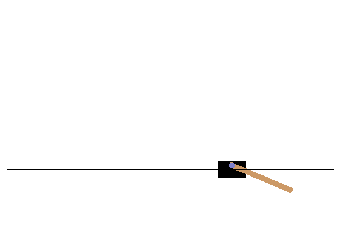

In [3]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(100):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
        
env.close()

# Policy Network

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2):
        super(Policy, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear = nn.Linear(state_size, action_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, state):
        logits = self.linear(state.to(device))
        action_probs = self.softmax(logits)
        return action_probs
    
    def act(self, state):
        action_probs = self.forward(state)
        action = action_probs.argmax(dim=1).cpu().item()
        return action
    
    def step(self, env, state):
        state = torch.from_numpy(state).view(-1, self.state_size).float().to(device)
        action = self.act(state)
        state, reward, done, _ = env.step(action)
        return state, reward, done
    
    def get_weights(self):
        return self.linear.weight 
    
    def update_weights(self, new_weights):
        self.linear.weight = nn.Parameter(new_weights.to(device))
        
    def add_to_weight(self, addition_weight):
        with torch.no_grad():
            self.linear.weight  +=  nn.Parameter(addition_weight.to(device))
    
    def save_model(self, filename='trained_model.pth'):
        torch.save(self.state_dict(), filename)
        
    def load_model(self, filename='trained_model.pth'):
        self.load_state_dict(torch.load(filename))

In [5]:
x = torch.randn(1,4).to(device)
policy = Policy().to(device)
policy(x), policy.act(x)

(tensor([[ 0.4797,  0.5203]], device='cuda:0'), 1)

In [6]:
policy.step(env, env.reset())

(array([-0.01948389,  0.23156741,  0.04262502, -0.24739439]), 1.0, False)

In [7]:
policy.get_weights()

Parameter containing:
tensor([[ 0.2855, -0.4036, -0.2913,  0.4627],
        [-0.0478,  0.2436,  0.4406,  0.3721]], device='cuda:0')

In [8]:
policy.update_weights(torch.ones(policy.linear.weight.data.shape))
policy.get_weights()

Parameter containing:
tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]], device='cuda:0')

In [9]:
policy.add_to_weight(torch.ones(policy.linear.weight.data.shape))
policy.linear.weight 

Parameter containing:
tensor([[ 2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.]], device='cuda:0')

## Policy of untrained policy network

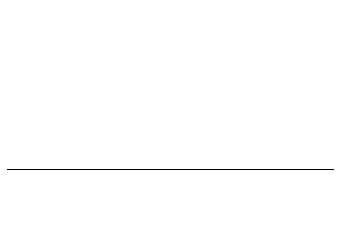

In [6]:
import imageio
images = []

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(500):
    state = torch.from_numpy(state).view(-1, 4).float()
    action = policy.act(state)
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)

env.close()
kargs = { 'fps': 100 }
imageio.mimsave('1_random_policy.gif', images, **kargs)

# Train the Agent

In [11]:
def train_policy_network(policy, n_episodes=2000, max_time=2000, gamma=1.0, print_every=100, noise_scale=1e-3):
    scores_deque = deque(maxlen=100)
    scores = []
    best_Reward = -np.Inf
    best_Weights = policy.get_weights()
    
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_time):
            state = torch.from_numpy(state).view(-1, 4).float()
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done: break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        Reward = sum([a*b for a,b in zip(discounts, rewards)])
        
        if Reward >= best_Reward:
            best_Reward = Reward
            best_Weights = policy.get_weights()
            noise_scale = max(1e-3, noise_scale/2)
            policy.add_to_weight(noise_scale * torch.randn(policy.get_weights().shape))
        else:
            noise_scale = min(2, noise_scale * 2)
            policy.update_weights(best_Weights + noise_scale * torch.randn(policy.get_weights().shape).to(device))
            
        if i_episode % print_every == 0:
            print('Episode {}\tLatest Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(scores_deque)))
    return policy, scores

In [12]:
device = torch.device("cpu")
policy = Policy().to(device)
print(policy.get_weights())
for param in policy.parameters():
    param.requires_grad = False
    
t1 = time.time()
policy, scores = train_policy_network(policy)
t2 = time.time()
print('CPU Time = ', t2-t1)

policy.save_model('trained_hill_climbing.pth')

Parameter containing:
tensor([[ 0.1166,  0.1913, -0.1814, -0.3876],
        [-0.1283,  0.2113, -0.0179,  0.2768]])
Episode 100	Latest Score: 200.00	Average Score: 134.42
Episode 200	Latest Score: 200.00	Average Score: 200.00
Episode 300	Latest Score: 200.00	Average Score: 200.00
Episode 400	Latest Score: 200.00	Average Score: 200.00
Episode 500	Latest Score: 200.00	Average Score: 200.00
Episode 600	Latest Score: 200.00	Average Score: 200.00
Episode 700	Latest Score: 200.00	Average Score: 200.00
Episode 800	Latest Score: 200.00	Average Score: 200.00
Episode 900	Latest Score: 200.00	Average Score: 200.00
Episode 1000	Latest Score: 200.00	Average Score: 200.00
Episode 1100	Latest Score: 200.00	Average Score: 200.00
Episode 1200	Latest Score: 200.00	Average Score: 200.00
Episode 1300	Latest Score: 200.00	Average Score: 200.00
Episode 1400	Latest Score: 200.00	Average Score: 200.00
Episode 1500	Latest Score: 200.00	Average Score: 200.00
Episode 1600	Latest Score: 200.00	Average Score: 200.0

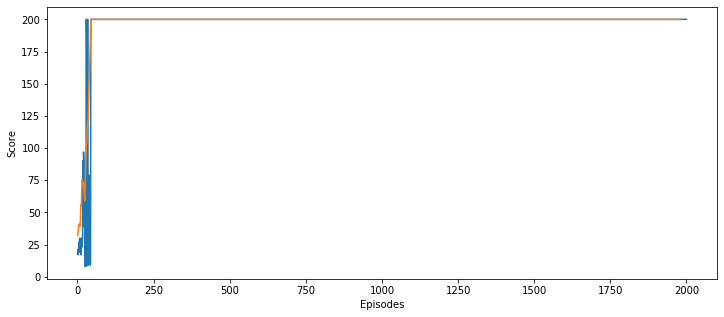

In [13]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

running_mean_scores = running_mean(scores, 20)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(running_mean_scores)+1), running_mean_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

# Trained Agent

Done at  199


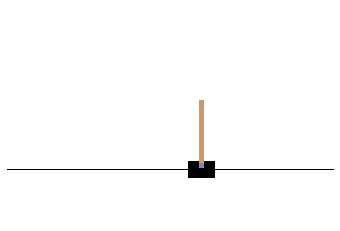

In [14]:
import imageio
images = []

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(500):
    state = torch.from_numpy(state).view(-1, 4).float()
    action = policy.act(state)
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Done at ', j)
        break
        
env.close()
kargs = { 'fps': 100 }
imageio.mimsave('2_trained_hill_climbing.gif', images, **kargs)

In [15]:
policy.get_weights()

Parameter containing:
tensor([[ 5.5798,  0.5197, -5.5435, -7.0717],
        [ 5.8716,  5.7923,  7.2549,  0.0199]])